In [323]:
import numpy as np
import matplotlib.pyplot as plt

Vi genererar slumpmässig datapunkter uniformt på $[0,1]^2$

In [324]:
np.random.seed(133)
N = 20 #number of data points
x = np.random.uniform(0,1, size = (N,2))

Sedan så definerar vi ett plan (eller en linje eftersom vi är i 2d) så om punkterna ligger ovanför så får de label y = 1 0ch ligger de under får de label y= 0

linjens exvation ges av $\vec{n}\cdot \vec{x} = c$ så punkterna får label 1 om 
$$ \vec{n}\cdot \vec{x} > c $$

In [325]:
#n,c are the parameters fo for the hyperplane separating the two sets n*x=c
n = np.array([1,2])
c = 1.4
y = np.zeros((N,)) #labels
for i in range(N):
    if (np.dot(n,x[i,:])>c):
        y[i] = 1

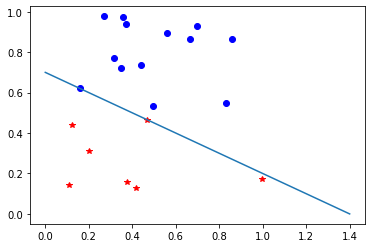

In [326]:
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane

Nu ska vi göre en logistisk regression. Vi har modellen 
$$f_{\omega_0,\omega_1,\omega_2}(x_1,x_2) = P(Y = 1|x,\vec{\omega}) = \frac{1}{1+e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}} = \frac{e^{(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}}{1+e^{(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}}$$
Och loss funktionen
$$L(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2),y) = -y\log(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2)) - (1-y)\log(1-f_{\omega_0,\omega_1,\omega_2}(x_1,x_2))$$
Så lossen för all våran data är
$$L = -\sum_{i=0}^N y^i\log(f_{\omega_0,\omega_1,\omega_2}(x^i_1,x^i_2)) + (1-y^i)\log(1-f_{\omega_0,\omega_1,\omega_2}(x^i_1,x^i_2))$$
Det är den här lossen vi vill minimera med någon metod. Alltså hitta de optimala parametrarna $\omega_0,\omega_1,\omega_2$

In [327]:
def f(x,w):
    """Output of the neural network, where w is the 3D vector containing the weights and x1 and x2 are the 
    input coordinates. Outputs a value in the range [0,1]. """
    a = w[0]+w[1]*x[0]+w[2]*x[1];
    return 1/(1+np.exp(-a))

In [328]:
def loss(x,w,y):
    #log-loss or binary cross-entropy is used
    #Returns value -y*np.log(f(x1,x2,w))-(1-y)*np.log(1-f(x1,x2,w))
    if y == 1:
        return -np.log(f(x,w))
    else:
        return -np.log(1-f(x,w))

In [329]:
def total_loss(w):
    #This is the total log-loss from all training data.
    L = 0
    for i in range(N):
        L += loss(x[i,:],w,y[i])
    return L/N
    

Använder kedjeregeln så att vi kan utnyttja att $\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial f}\frac{\partial f}{\partial a}\frac{\partial a}{\partial w_i}$

In [351]:
def gradient_sample(w,x,y):
    #Computes the gradient with respect to one sample only by using backpropagation (the chain rule)
    
    #xvec = np.array([1,x[0],x[1]])
    #return xvec*(-y+1/(1+np.exp(w@xvec))) #Division by zero in log if this is used
    
    a = w[0]+w[1]*x[0]+w[2]*x[1];
    dfda = np.exp(-a)/((1+np.exp(-a))**2)
    
    dadw = np.array([1,x[0],x[1]])
    if y ==1:
        return -dfda*dadw/f(x,w)
    else:
        return dfda*dadw/(1-f(x,w))
    


In [352]:
def gradient(w,x = x,y=y):
    #Computes total gradient 
    g = 0
    for i in range(N):
        g = g+gradient_sample(w,x[i,:],y[i])
    return g

In [353]:
train_sessions = 20000
alpha = 1

w = np.random.normal(size = (3,))
SGD = 0
E = []

for i in range(train_sessions):
    #If training with gradient descent
    if not SGD:
        w = w-alpha*gradient(w,x,y)
    else:    
        #If training with SGD - can I choose the same sample multiple times?
        k = np.random.randint(0,N)
        w = w-alpha*gradient_sample(w,x[k,:],y[k])
    
    if i%N == 0:
        E.append(total_loss(w))

[-58.78637245  14.96418414 103.52936537]


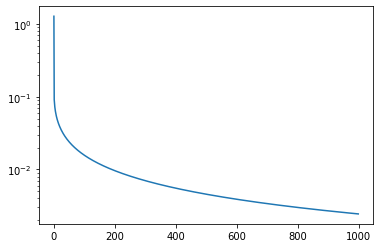

In [354]:
plt.figure()
plt.semilogy(E)
print(w)

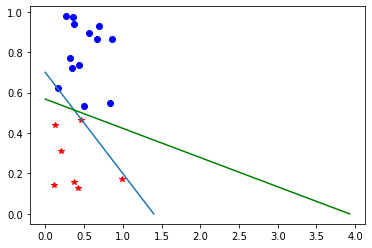

In [355]:
plt.figure()
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane
plt.plot([0,-w[0]/w[1]],[-w[0]/w[2],0],'g') #plots the trained hyperplane


## (Statistisk överkurs)
Om man undrar var lossen kommer ifrån så kan man ur ett statistiskt perspektiv se det såhär. Vi modelerar $y|x \sim Ber(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2))$. Då blir Likelihooden för vår data
$$P(y^1,y^2\cdots,y^N|x^1,x^2\cdots x^N) = \prod_{i=1}^NP(y^i|x^i) = \prod_{i=1} (f_{\omega_0,\omega_1,\omega_2}(x_1,x_2))^{y_i}(1-f_{\omega_0,\omega_1,\omega_2}(x_1,x_2))^{1-y_1}$$
För att sannoliketsfunktionen till en $Ber(\theta)$ variabl kan skrivas som $p_Y(y) = \theta^y(1-\theta)^{1-y}$. Att maximera likelihooden är samma sak som att minimera negativ logaritmen av likelihoode. Det är det vi gör ovan. Så att minimera lossen (Som i maskininlärningsvärlden kalla cross-entropy) är helt enkelt att hitta ML-skattningen av variablerna.

## Avancerade optimeringsstrategier

Vi väljer nu att istället optimera nätverket genom att använda någon av optimeringsmetoderna Conjugate gradient, BFGS eller L-BFGS. För detta använder vi färdigskrivna bibliotek från scipy. 


In [298]:
import scipy.optimize

#### Conjugate gradient:

In [308]:
w = np.random.normal(size = (3,))
res1 = scipy.optimize.fmin_cg(total_loss, w, fprime=gradient,gtol=1e-02,maxiter = 20000,full_output=True)
xopt,fopt,*rest = res1
print("found parameters are", xopt)
print("loss function value is",fopt)

Optimization terminated successfully.
         Current function value: 0.000442
         Iterations: 19
         Function evaluations: 77
         Gradient evaluations: 77
found parameters are [-107.1738925    47.40393754  168.75774976]
loss function value is 0.00044154048824596057


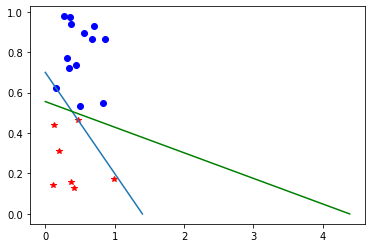

In [309]:
plt.figure()
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane
plt.plot([0,-w2[0]/w2[1]],[-w2[0]/w2[2],0],'g') #plots the trained hyperplane

#### BFGS

In [310]:
w = np.random.normal(size = (3,))
res = scipy.optimize.fmin_bfgs(total_loss, w, fprime=gradient,gtol=1e-01,maxiter = 20000, full_output=True)

xopt,fopt,gopt,Bopt,func_calls,grad_calls, warnflag = res #unpack
print("found parameters are", xopt)
print("loss function value is",fopt)


Optimization terminated successfully.
         Current function value: 0.072270
         Iterations: 15
         Function evaluations: 36
         Gradient evaluations: 36
found parameters are [-9.66829517  2.20665352 17.71948269]
loss function value is 0.07227013718958943


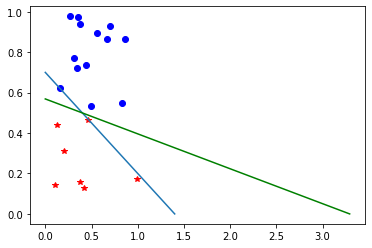

In [311]:
plt.figure()
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane
plt.plot([0,-w3[0]/w3[1]],[-w3[0]/w3[2],0],'g') #plots the trained hyperplane